### PHASE 1: DATA GATHERING:
Create a graph of Rivers State using osmnx, retrieve nodes from googlemaps api and store everything as a .geojson file.


In [ ]:
!pip install osmnx


In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import networkx as nx
import pyproj
from shapely.ops import unary_union
from shapely.geometry import Point
from shapely.ops import transform


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
project_implementation_folder = "/content/drive/MyDrive/Final Year Project/Project Code, Resources and Implementation"


Mounted at /content/drive


In [ ]:
all_local_govs = gpd.read_file("/content/drive/MyDrive/Final Year Project/Project Code, Resources and Implementation/Resources/geoBoundaries-NGA-ADM2.geojson")

## Codebase Redo


In [ ]:
# Get Obio-akpor Boundaries
lga = all_local_govs[all_local_govs["shapeName"] == "Obio/Akpor"]

# Base GeoDataFrame
base_gdf = gpd.GeoDataFrame(geometry=lga.geometry, crs="EPSG:4326")

# Road network
road_network = ox.graph_from_polygon(lga.geometry.iloc[0], network_type="drive")
road_edges_gdf = ox.graph_to_gdfs(road_network, nodes=False, edges=True)


In [ ]:
'''
# Plot all together

ax = base_gdf.plot(facecolor="black", edgecolor="black", figsize=(12,12), linewidth=2)
road_edges_gdf.plot(ax=ax, linewidth=1, edgecolor="gray")
hospitals_gdf.plot(ax=ax, color="orange", markersize=50, marker="o")
plt.title("Obio/Akpor: Roads and Hospitals", fontsize=16)
plt.show()
'''

'\n# Plot all together\n\nax = base_gdf.plot(facecolor="black", edgecolor="black", figsize=(12,12), linewidth=2)\nroad_edges_gdf.plot(ax=ax, linewidth=1, edgecolor="gray")\nhospitals_gdf.plot(ax=ax, color="orange", markersize=50, marker="o")\nplt.title("Obio/Akpor: Roads and Hospitals", fontsize=16)\nplt.show()\n'

### NOTE
OpenStreetMaps is not rich in nodes we're interested in(hospitals) so, what I did was manually create and update a csv file that contains all hospitals in the study region and their rating. It is these hospitals that we'll be plotting on our base map no longer the ones already integrated into OpenStreetMaps.
```# Hospitals and clinics
tags = {"amenity": ["hospital", "clinic"]}
hospitals_gdf = ox.features.features_from_polygon(lga.geometry.iloc[0], tags=tags)
hospitals_gdf = hospitals_gdf[["name", "geometry"]].dropna(subset=["name"])

```
In the next couple of cells we'll import that file into this notebook, convert to geodataframe and layer on our base map

In [ ]:
# Load hospitals from CSV
hospital_data = pd.read_csv("/content/drive/MyDrive/Final Year Project/Project Code, Resources and Implementation/Resources/hospital_data.csv.csv")

print(hospital_data.head())
print(hospital_data.columns)


                                            name  latitude  longitude  \
0                          Obio Cottage Hospital  4.826647   7.038318   
1                             RAHI Hospitals Ltd  4.882853   6.936570   
2  St. William's Alpha Specialist Medical Centre  4.876807   6.933337   
3                     Ozuoba Primary Health Care  4.871316   6.929127   
4                      St. Jude's Medical Clinic  4.848118   7.064447   

   serviceQualityRating  reviewCount  adjustedRating  
0                   4.0           82        4.020460  
1                   4.1           15        4.135294  
2                   5.0            3        4.375566  
3                   3.5           13        3.799233  
4                   3.7           15        3.895294  
Index(['name', 'latitude', 'longitude', 'serviceQualityRating', 'reviewCount',
       'adjustedRating'],
      dtype='object')


The study takes into account hospital service rating and while this value can seem really good for the analysis it can also skew analysis results as one 5 star rating would weigh more than fifty 4.5 star ratings which is simply misleading.
As a quick get-around, we'll be using the Bayesian average adjustment:

```adjustedRating=(v/v + m)R + (m/v + m)C```

With:


*   R = hospital's average rating
*   v = number of reviews
*   C = global mean rating across all hospitals
*   m = minimum reviews threshold


In [ ]:
C = hospital_data["serviceQualityRating"].mean()
m = 10
# Adjust ratings
hospital_data["adjustedRating"] = (
    (hospital_data["reviewCount"] / (hospital_data["reviewCount"] + m)) * hospital_data["serviceQualityRating"] +
    (m / (hospital_data["reviewCount"] + m)) * C
)
# csv update
hospital_data.to_csv("/content/drive/MyDrive/Final Year Project/Project Code, Resources and Implementation/Resources/hospital_data.csv.csv", index=False)

# Convert hospitals DataFrame to GeoDataFrame
hospital_gdf = gpd.GeoDataFrame(
    hospital_data,
    geometry=gpd.points_from_xy(hospital_data.longitude, hospital_data.latitude),
    crs="EPSG:4326"  # WGS84 coordinate system
)

In [ ]:
# Keep only hospitals within the study polygon
hospital_gdf = hospital_gdf[hospital_gdf.within(base_gdf.union_all())]


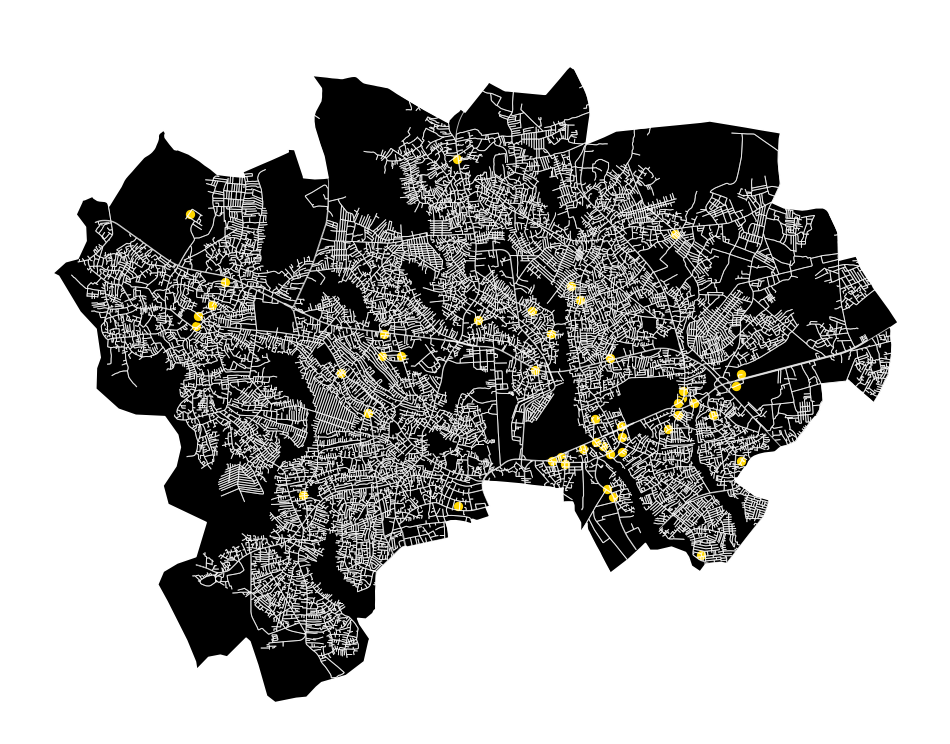

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_facecolor("black")

# Study region polygon
base_gdf.plot(ax=ax, facecolor="black", edgecolor="white", linewidth=1.2)
road_edges_gdf.plot(ax=ax, linewidth=0.7, edgecolor="white", alpha=0.7)
# Hospitals
hospital_gdf.plot(ax=ax, color="gold", edgecolor="black", markersize=60, marker="o")

ax.set_axis_off()
plt.title("Obio/Akpor: Roads and Hospitals", color="white", fontsize=16)
plt.show()


---
### PHASE 2: Route Optimisation
---
In Phase 2 we will:


1.   Confirm graph edges have proper weights (distance and travel time).
2.   Implement One-to-Many Shortest Path Algorithm

 - Use Dijkstra’s algorithm to compute shortest paths from any emergency origin to all hospitals.
3.  Compute Route Metrics

 - Calculate distance, travel time, hospital capacity, and service rating for each route.
 - Identify the 2 closest hospitals considering these factors.

4. Visualization of Routes

 - Map all computed routes on the Obio-Akpor boundary.

 - Highlight the 2 closest hospitals and optionally color-code alternative hospitals.



In [ ]:
#%cd "/content/drive/MyDrive/Final Year Project/Project Code, Resources and Implementation"


In [ ]:
'''
!git config --global user.email "smartemmanuel1234@gmail.com"
!git config --global user.name "SIEcoder"
!git pull origin main
!git add .
!git commit -m "Reassigned Bayesian adjustment threshold to 10 from 20"
!git push origin main
'''

In [ ]:
# Project road network to UTM (meters)
road_network_proj = ox.project_graph(road_network)

# Get projected edges (lengths in meters now)
road_edges_proj_gdf = ox.graph_to_gdfs(road_network_proj, nodes=False, edges=True)

print(road_edges_proj_gdf.crs)   # should show a projected CRS (UTM zone)
print(road_edges_proj_gdf[["length"]].head())  # lengths in meters


EPSG:32632
                               length
u          v          key            
252485102  5412722616 0     48.886671
5412722616 3784480936 0    556.891582
           6510692857 0    126.777801
252486156  7321140780 0      8.133163
           5416888599 0     64.177226


The road network edges initially contained distances and, in some cases, maximum speed limits. To estimate travel time across each road segment, we first created a mapping of road types to average speeds based on FRSC speed limits for different road types.

Next, we calculated travel time for each edge using the formula:

```time (seconds)
=
length (meters)/
speed (m/s)```

Finally, we converted these values into human-readable units. If the computed time was under 60 seconds, it was expressed in seconds; under 60 minutes, in minutes; under 24 hours, in hours; otherwise, in days. This makes the travel time data easier to interpret while still being suitable for use as routing weights in the network graph.

In [ ]:
import numpy as np

# Lookup (cars, km/h)
speed_by_highway = {
    "motorway": 100,
    "motorway_link": 100,
    "trunk": 80,
    "trunk_link": 80,
    "primary": 80,
    "primary_link": 80,
    "secondary": 60,
    "secondary_link": 60,
    "tertiary": 50,
    "tertiary_link": 50,
    "unclassified": 50,
    "residential": 50,
    "living_street": 30,
    "service": 30,
    "track": 30,
    "pedestrian": 10,
    "footway": 5,
    "cycleway": 15,
    None: 30
}

def extract_hw(hw):
    if isinstance(hw, (list, tuple)):
        return hw[0]
    return hw

def assign_speed(row):
    hw = extract_hw(row.get('highway'))
    return speed_by_highway.get(hw, speed_by_highway[None])

# assign speed_kph by highway type
road_edges_proj_gdf['speed_kph'] = road_edges_proj_gdf.apply(assign_speed, axis=1)

# ensure length_m column
if 'length' in road_edges_gdf.columns:
    road_edges_proj_gdf['length_m'] = road_edges_proj_gdf['length']
else:
    road_edges_proj_gdf['length_m'] = road_edges_proj_gdf.geometry.length

# convert to m/s
road_edges_proj_gdf['speed_mps'] = road_edges_proj_gdf['speed_kph'] * 1000 / 3600

# travel time in seconds
road_edges_proj_gdf['travel_time_s'] = road_edges_proj_gdf['length_m'] / road_edges_proj_gdf['speed_mps']

# human-readable formatting
def format_time(seconds):
    if seconds < 60:
        return f"{seconds:.1f} sec"
    elif seconds < 3600:
        return f"{seconds/60:.1f} min"
    elif seconds < 86400:
        return f"{seconds/3600:.2f} hr"
    else:
        return f"{seconds/86400:.2f} days"

road_edges_proj_gdf['travel_time_fmt'] = road_edges_proj_gdf['travel_time_s'].apply(format_time)

# check result
print(road_edges_proj_gdf[['highway','speed_kph','length_m','travel_time_s','travel_time_fmt']].head(10))


At this stage, the hospitals exist as independent geographic points, while the road network is represented as a graph of nodes and edges. To integrate hospitals into routing, we must snap each hospital location to the road network. Snapping ensures that every hospital is associated with its nearest road node (or edge), making it possible to compute routes that start or end at the hospital. Without this step, hospitals would remain “floating” points outside the network and shortest-path algorithms would not be able to reach them.

In [ ]:

# Ensure hospital CRS matches the projected road network
hospital_gdf = hospital_gdf.to_crs(road_edges_proj_gdf.crs)

# Use the projected road network
G = road_network_proj

# Snap hospitals to nearest road network nodes
hospital_gdf["nearest_node"] = hospital_gdf.geometry.apply(
    lambda point: ox.distance.nearest_nodes(G, point.x, point.y)
)

hospital_gdf.head()


Calculate circuity for each hospital


In [ ]:


def compute_circuity(G, origin_node, dest_node):
    """
    Compute circuity ratio = shortest path length / straight-line distance.
    Requires a projected graph (units = meters).
    """
    # shortest network distance (meters)
    shortest_path_length = nx.shortest_path_length(G, origin_node, dest_node, weight="length")

    # coordinates of origin and destination
    origin_xy = (G.nodes[origin_node]['x'], G.nodes[origin_node]['y'])
    dest_xy = (G.nodes[dest_node]['x'], G.nodes[dest_node]['y'])

    # straight-line distance (euclidean in projected CRS)
    ox = origin_xy[0] - dest_xy[0]
    oy = origin_xy[1] - dest_xy[1]
    straight_line_distance = (ox**2 + oy**2) ** 0.5

    return shortest_path_length / straight_line_distance if straight_line_distance > 0 else None


Create setup to recieve user location, snap coordinates to nearest node and store this snapped coordinate as ```origin_node```. That will be done through a function: ```set_origin(user_lat, user_lon, G)```

In [ ]:
# This is to check if the origin_node setup works properly
# Example test coordinates
user_lat, user_lon = 4.883331922753394, 7.042260858420209   # Port Harcourt coords

# Snap coordinates to nearest node in the graph
origin_node = ox.distance.nearest_nodes(G, X=user_lon, Y=user_lat)

print("Origin node:", origin_node)


Origin node: 5392721242


In [ ]:
'''
# Function to receive user location (lat, lon) dynamically
def set_origin(user_lat, user_lon, G):
    """
    Takes user's geolocation coordinates (lat, lon)
    and returns the nearest graph node ID as origin.
    """
    origin_node = ox.distance.nearest_nodes(G, user_lon, user_lat)
    return origin_node

# Example usage:
# Later, this will be called with real browser geolocation input.
# For now, just leave it as a function to be used by the app.
'''

Next we'll compute travel times from origin node to every hospital using the ```travel_time``` edge weight

In [ ]:
def compute_travel_times(G, origin_node, hospital_nodes):
    travel_times = {}
    for hosp, hosp_node in hospital_nodes.items():
        try:
            # Shortest path using travel_time weight
            time_seconds = nx.shortest_path_length(
                G,
                source=origin_node,
                target=hosp_node,
                weight="travel_time"
            )
            travel_times[hosp] = time_seconds / 60  # convert to minutes
        except nx.NetworkXNoPath:
            travel_times[hosp] = float("inf")  # no path found
    return travel_times


# --- Example usage (replace with your own data) ---

# Push travel_time_s from edges GeoDataFrame into the projected graph
for u, v, k, data in road_network_proj.edges(keys=True, data=True):
    if (u, v, k) in road_edges_proj_gdf.index:
        data["travel_time"] = road_edges_proj_gdf.loc[(u, v, k), "travel_time_s"]

# User coordinates
user_lat, user_lon = 4.883331922753394, 7.042260858420209   # Port Harcourt coords

# Snap coordinates to nearest node in the projected graph
origin_node = ox.distance.nearest_nodes(road_network_proj, X=user_lon, Y=user_lat)

# Build mapping of hospital name -> nearest road network node
hospital_nodes = dict(zip(hospital_gdf["name"], hospital_gdf["nearest_node"]))

# Call the function
travel_times = compute_travel_times(road_network_proj, origin_node, hospital_nodes)

print("Computed travel times (minutes):")
for hosp, t in travel_times.items():
    print(f"{hosp}: {t:.2f}")


We can now compute travel times from origin to all hospitals. What we'll proceed to do is handle the cost function.

In [71]:
# 1. Convert travel_times dict to DataFrame
travel_df = pd.DataFrame(list(travel_times.items()), columns=["name", "t_minutes"])

# 2. Select and rename rating column from hospital_gdf
hospital_ratings = hospital_gdf[["name", "adjustedRating"]].rename(
    columns={"adjustedRating": "adj_rating"}
)

# 3. Merge travel times with ratings
hospital_cost_df = hospital_ratings.merge(travel_df, on="name")

# 4. Remove rows with infinite travel times if any
hospital_cost_df = hospital_cost_df[hospital_cost_df["t_minutes"] != float("inf")].reset_index(drop=True)

# 5. Normalize travel times (T_norm)
t_min, t_max = hospital_cost_df["t_minutes"].min(), hospital_cost_df["t_minutes"].max()
hospital_cost_df["T_norm"] = (hospital_cost_df["t_minutes"] - t_min) / (t_max - t_min)

# 6. Normalize adjusted ratings (R_norm)
r_min, r_max = hospital_cost_df["adj_rating"].min(), hospital_cost_df["adj_rating"].max()
hospital_cost_df["R_norm"] = (r_max - hospital_cost_df["adj_rating"]) / (r_max - r_min)

# 7. Compute cost with alpha weighting
alpha = 0.5
beta = 1 - alpha
hospital_cost_df["cost"] = alpha * hospital_cost_df["T_norm"] + beta * hospital_cost_df["R_norm"]

# 8. Sort hospitals by cost (lowest = best)
hospital_cost_df = hospital_cost_df.sort_values("cost").reset_index(drop=True)

best_hospital = hospital_cost_df.loc[hospital_cost_df["cost"].idxmin(), "name"]
print(best_hospital)

#hospital_cost_df


Nissi Medical Centre


Now the algorithm can select a 'best' hospital given the values of ```alpha```. We'll proceed to grab coordinates of the selected hospital for printing on the map.

In [73]:
# Merge cost dataframe with hospital geometries
hospital_map_df = hospital_cost_df.merge(
    hospital_gdf[["name", "geometry"]],
    on="name"
)
# Grab its coordinates
best_hospital_coords = hospital_map_df.loc[hospital_map_df["name"] == best_hospital, "geometry"].values[0]

#print(best_hospital, best_hospital_coords)


In [ ]:
%cd "/content/drive/MyDrive/Final Year Project/Project Code, Resources and Implementation"


In [76]:
!rm -f .git/index.lock


In [ ]:
!ls -al ~/.ssh


In [82]:
!git config --global user.name "SIEcoder"
!git config --global user.email "smartemmanuel1234@gmail.com"


In [83]:
!git remote set-url origin git@github.com:SIEcoder/Emmergency-Routing-Project.git


In [ ]:
!git add .
!git commit -m "Implemented cost function, computed travel times, and mapped rating(adjusted) to each hospital. Current setup can take in user location and select best hospital depending on alpha"
!git push origin main


In [85]:
!ssh -T git@github.com


Host key verification failed.


In [86]:
!git remote -v


origin	git@github.com:SIEcoder/Emmergency-Routing-Project.git (fetch)
origin	git@github.com:SIEcoder/Emmergency-Routing-Project.git (push)
